In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import skbio
import os

import asd
%matplotlib inline

In [2]:
data_dir = "../microbiome-data/run1-4/vsearch-100/cd_even5721/"
uu_fp = os.path.join(data_dir, "bdiv_even5721/unweighted_unifrac_dm.txt")
wu_fp = os.path.join(data_dir, "bdiv_even5721/weighted_unifrac_dm.txt")
faithpd_fp = os.path.join(data_dir, "arare_max5721/alpha_div_collated/PD_whole_tree.txt")
sample_md_fp = 'combined-map.tsv'

In [3]:
!md5 $uu_fp
!md5 $wu_fp
!md5 $faithpd_fp

MD5 (../microbiome-data/run1-4/vsearch-100/cd_even5721/bdiv_even5721/unweighted_unifrac_dm.txt) = 911f6201d9ca50fb4ad8d4f497b67c7c
MD5 (../microbiome-data/run1-4/vsearch-100/cd_even5721/bdiv_even5721/weighted_unifrac_dm.txt) = 461654a411945af70f514079473457e3
MD5 (../microbiome-data/run1-4/vsearch-100/cd_even5721/arare_max5721/alpha_div_collated/PD_whole_tree.txt) = 86263991aae5bb2df4a5305e40759cca


In [4]:
sample_md = pd.read_csv(sample_md_fp, sep='\t', index_col=0, dtype=object)
wu_dm = skbio.DistanceMatrix.read(wu_fp)
uu_dm = skbio.DistanceMatrix.read(uu_fp)

In [5]:
faithpd = pd.read_csv(faithpd_fp, sep='\t')

In [6]:
asd.get_donor_sids(sample_md)

{'BBT2014-00029': '6519888d.bb69.495b.b4b8.07d0d4333455',
 'BBT2014-00035': '8d2746d9.68e2.42e3.acfc.092603ad6ec1',
 'BBT2014-00036': '2756472a.03f4.41da.8564.1d7538f949c6',
 'BBT2014-00037': 'b986755d.b15a.4ad4.b6a2.0c7cdd9b8ced',
 'BBT2014-00038': '78ff0b74.3d7e.4ed5.8c2d.a5f77b793718',
 'MD2014-00002': 'ab7ea93a.ebce.4ecf.a56d.01441d5605b3',
 'MD2014-00003': '2ce1e761.4f19.4236.a6a5.49ac820af545'}

In [7]:
sample_md = asd.add_distance_to_donor(sample_md, uu_dm, metric_name='unweighted UniFrac')
sample_md = asd.add_distance_to_donor(sample_md, wu_dm, metric_name='weighted UniFrac')

In [8]:
sample_md = asd.add_alpha_diversity(sample_md, faithpd, 'Faith PD')

In [9]:
sample_md

,OldSampleID,BarcodeSequence,LinkerPrimerSequence,run,SampleType,Group,SubjectID,time_point,sequences.per.sample,MostRecentDonorID,...,BMI,r1-3.sequences.per.sample,mom_kid,sample_repeat,Description,unweighted UniFrac to initial donor,unweighted UniFrac to most relevant donor,weighted UniFrac to initial donor,weighted UniFrac to most relevant donor,Faith PD
#SampleID,,,,,,,,,,,,,,,,,,,,,
595e93ed.e4b3.42b5.91b1.1ad4f31e7134,1.ST001,GTGCAACCAATC,GTGTGCCAGCMGCCGCGGTAA,1,stool,autism,B101,1,19724,pre-treatment,...,14.8,19707,kid,sample,1.ST001,0.773801,0.773801,0.368176,0.368176,43.072041
fa2e9bcc.cc53.4b83.ad1e.a308375854f5,1.SW001,TCCCTTGTCTCC,GTGTGCCAGCMGCCGCGGTAA,1,swab,autism,B101,1,24065,pre-treatment,...,14.8,24045,kid,sample,1.SW001,0.810820,0.810820,0.750709,0.750709,33.395722
b1e40907.45fc.4d81.ad81.c58ed3d91e1f,1.SW002,CGGTCAATTGAC,GTGTGCCAGCMGCCGCGGTAA,1,swab,autism,B101,2,50266,pre-treatment,...,14.8,50245,kid,sample,1.SW002,0.862072,0.862072,0.896594,0.896594,25.177777
bd64992d.87cc.464f.9e1b.9c0156ed65d8,1.ST002,TGTGCGATAACA,GTGTGCCAGCMGCCGCGGTAA,1,stool,autism,B101,2,28140,BBT2014-00029,...,14.8,28106,kid,sample,1.ST002,0.646242,0.646242,0.339452,0.339452,55.483458
c784e063.e586.43cb.a602.9f2e2ae420d1,1.SW003,AGTCGAACGAGG,GTGTGCCAGCMGCCGCGGTAA,1,swab,autism,B101,3,74215,BBT2014-00029,...,14.8,74124,kid,sample,1.SW003,0.691281,0.691281,0.579655,0.579655,50.545840
cc52726a.bed3.4840.a146.2a4c58978b89,1.SW004,GCATAGCATCAA,GTGTGCCAGCMGCCGCGGTAA,3,swab,autism,B101,4,16002,MD2014-00002,...,14.8,15983,kid,sample,1.SW004,0.670702,0.695673,0.314118,0.493147,55.134943
104e5902.1c3e.417f.bb22.124bfca61a61,1.SW005,ACCATAGCTCCG,GTGTGCCAGCMGCCGCGGTAA,1,swab,autism,B101,5,81136,MD2014-00002,...,14.8,81040,kid,sample,1.SW005,0.727498,0.740768,0.648746,0.835932,51.021397
7c66ff62.02e7.458d.a55d.8d07d15a9315,1.SW006,ATCACCAGGTGT,GTGTGCCAGCMGCCGCGGTAA,1,swab,autism,B101,6,56653,MD2014-00002,...,14.8,56594,kid,sample,1.SW006,0.725204,0.736413,0.493515,0.675537,52.857232
e7a2370c.f80c.4703.b2ee.10c65967e05f,1.ST003,GCGACAATTACA,GTGTGCCAGCMGCCGCGGTAA,1,stool,autism,B101,3,24792,MD2014-00002,...,14.8,24780,kid,sample,1.ST003,0.703337,0.681934,0.324309,0.429491,55.450872


## Change with time: swab

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


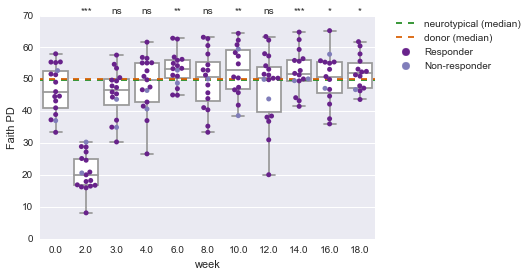

In [10]:
asd.plot_week_data_with_stats(sample_md, sample_type='swab', metric='Faith PD', hue='responder')

## Change with time: stool

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


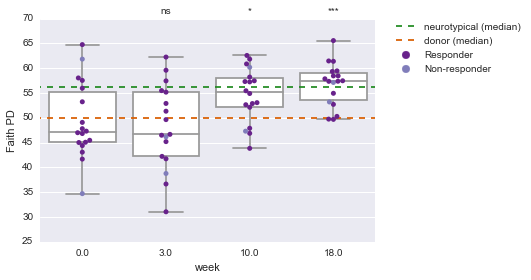

In [11]:
asd.plot_week_data_with_stats(sample_md, sample_type='stool',
               metric='Faith PD', hue='responder')

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


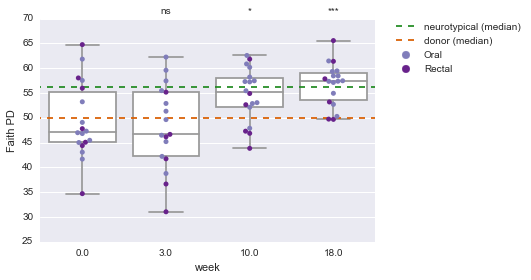

In [12]:
asd.plot_week_data_with_stats(sample_md, sample_type='stool',
               metric='Faith PD', hue='rectal_oral')

In [13]:
asd.tabulate_week_to_week0_paired_stats(sample_md, sample_type='stool',
                                    metric='Faith PD')

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


,n,Faith PD,t,p-value
week,,,,
0,0,NaN,NaN,NaN
3,17,-2.112889,-0.473846,0.642011
10,18,5.606396,2.867801,0.010665
18,18,7.388539,4.569975,0.000272


In [14]:
asd.tabulate_week_to_control_stats(sample_md, sample_type='stool',
                               metric='Faith PD')

,n,Faith PD,t,p-value
week,,,,
0,18,47.153514,-2.245377,0.030848
3,17,46.662844,-2.524965,0.016147
10,18,55.173771,-0.429916,0.670116
18,18,57.419133,0.467219,0.643908


## Engraftment: Swab

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


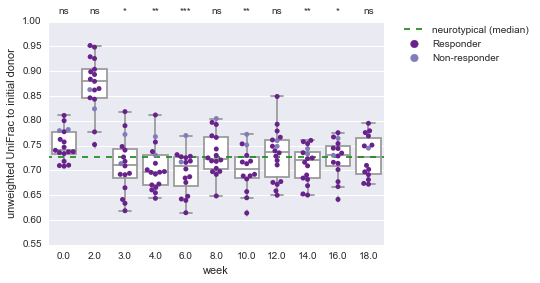

In [15]:
asd.plot_week_data_with_stats(sample_md, sample_type='swab',
                          metric='unweighted UniFrac to initial donor', hue='responder', one_tailed=True,
                          hide_donor_baseline=True)

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


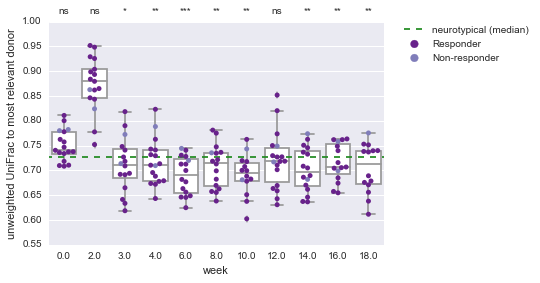

In [16]:
asd.plot_week_data_with_stats(sample_md, sample_type='swab',
                          metric='unweighted UniFrac to most relevant donor', hue='responder', one_tailed=True,
                          hide_donor_baseline=True)

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


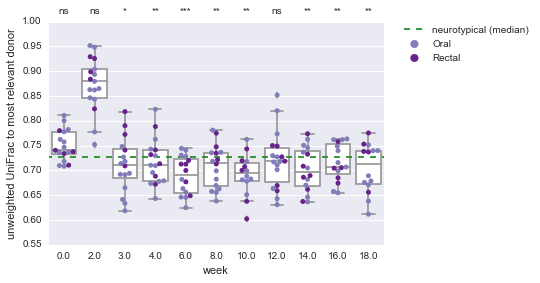

In [17]:
asd.plot_week_data_with_stats(sample_md, sample_type='swab',
                          metric='unweighted UniFrac to most relevant donor', hue='rectal_oral', one_tailed=True,
                          hide_donor_baseline=True)

## Engraftment: stool

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


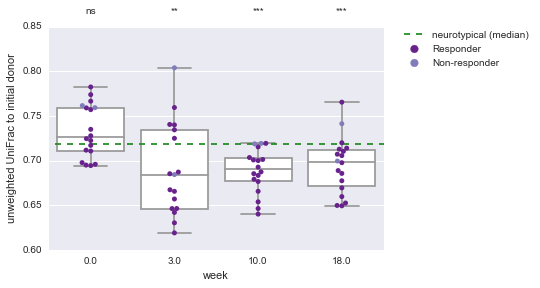

In [18]:
asd.plot_week_data_with_stats(sample_md, sample_type='stool',
                          metric='unweighted UniFrac to initial donor', hue='responder', one_tailed=True,
                          hide_donor_baseline=True)

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


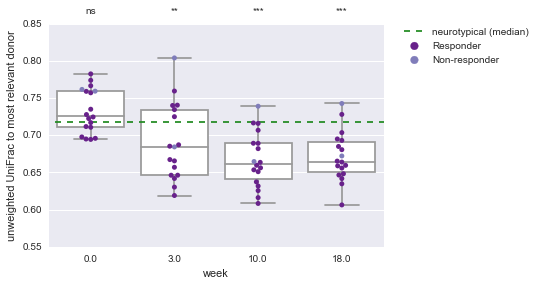

In [19]:
asd.plot_week_data_with_stats(sample_md, sample_type='stool',
                          metric='unweighted UniFrac to most relevant donor', hue='responder', one_tailed=True,
                          hide_donor_baseline=True)

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


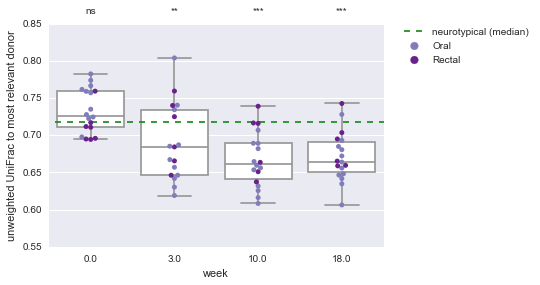

In [20]:
asd.plot_week_data_with_stats(sample_md, sample_type='stool',
                          metric='unweighted UniFrac to most relevant donor', hue='rectal_oral', one_tailed=True,
                          hide_donor_baseline=True)

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


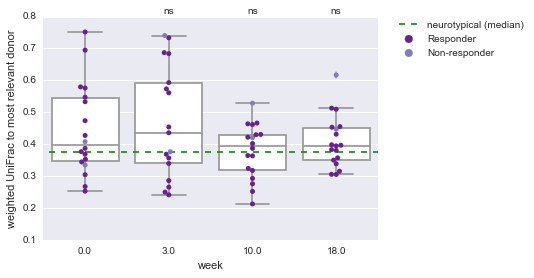

In [21]:
asd.plot_week_data_with_stats(sample_md, sample_type='stool',
                          metric='weighted UniFrac to most relevant donor', hue='responder', one_tailed=False,
                          hide_donor_baseline=True)

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


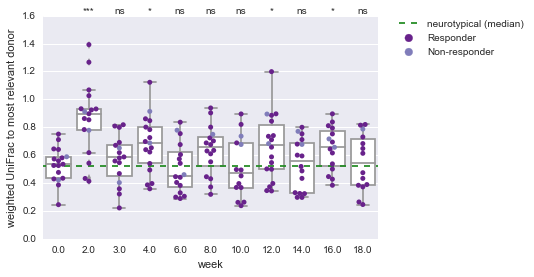

In [22]:
asd.plot_week_data_with_stats(sample_md, sample_type='swab',
                          metric='weighted UniFrac to most relevant donor', hue='responder', one_tailed=False,
                          hide_donor_baseline=True)